In [2]:
class Node:
    def __init__(self,alphabetSize = 26) -> None:
        self.start =None
        self.end = None
        self.children = alphabetSize * [None]
        self.suffixLink = None
        self.numberChildren = 0
    @property
    def end_value(self):
        return self.end[0] if self.end is not None else None
    
    def __str__(self) -> str:
        return f"start: {self.start}, end: {self.end}, children: {[child.start  for child in self.children if child!=None]}, suffixLink: {self.suffixLink}, numberChildren: {self.numberChildren}"

In [ ]:
a = [1]
b = a
a[0] = 2
b[0]

In [ ]:
val = [3]
a = Node(0,val)

print(a.end_value)

val[0] =5
print(a.end_value)


In [3]:
import graphviz

In [4]:
class SuffixTree:
    def __init__(self, minChar = 'a', maxChar = 'z', alphabetSize = 26) -> None:
        self.extension =0
        self.root = Node()
        self.root.start = 0
        self.end = [-1]
        self.activeNode = self.root
        self.activeEdge = -1
        self.activeLength = 0  
        self.lastJ= 0
        self.maxChar = maxChar
        self.minChar = minChar
    def add(self, s)->Node:
        newNode = Node()
        newNode.start = s # start index of the suffix
        newNode.end = self.end # global end
        newNode.suffixLink = self.root #set suffix link to root for now
        return newNode
    def __getCharIndex(self, char):
        return ord(char)-ord(self.minChar)
    
    def insert(self, text,activeNode, s, rem, verbose=False):
        remStart, remEnd = rem
        child = activeNode.children[self.__getCharIndex(text[s])] 
        newNode =self.add(s)
        #case 2a no need to create new branch
        if child is None:
            activeNode.children[self.__getCharIndex(text[s])] = newNode
            if verbose: print(f'rule 2 root node')
        elif child.numberChildren >0:
            child.children[self.__getCharIndex(text[s])] = newNode

        #case 2b - theres no branches from active node
        else:
            child = activeNode.children[self.__getCharIndex(text[remStart])] 
            child.end = [remEnd-1]
            remainingNode =self.add(remEnd)
            child.numberChildren += 2

            child.children[self.__getCharIndex(text[remEnd])] = remainingNode
            child.children[self.__getCharIndex(text[s])] = newNode
            if verbose: print(f'rule 2b new branch branching {s}, new text {self.__printSubString(text, activeNode)}, remaining text {self.__printSubString(text,remainingNode)} insert char {text[s]}')

        return
    
    
    def __insert(self,text, p, verbose=False):
        n = self.activeNode.children[self.__getCharIndex(text[self.activeEdge])]
        if n.numberChildren == 0:
            n.end = [n.start + (self.activeLength-1)]
            newRemNode = self.add(n.start+self.activeLength)
            newNode = self.add(p)

            n.children[self.__getCharIndex(text[newNode.start])] = newNode
            n.children[self.__getCharIndex(text[newRemNode.start])] = newRemNode
            n.numberChildren +=2
            if verbose: print(f'rule 2a branching {self.__printSubString(text, n)}, rem {self.__printSubString(text, newRemNode)}, new {self.__printSubString(text, newNode)}')
            
        else:
            #case 2b 
            newNode = self.add(p)
            n.children[self.__getCharIndex(text[p])] = newNode
            n.numberChildren +=1
            if verbose: print(f'rule 2b branching {self.__printSubString(text, n)}, new {self.__printSubString(text, newNode)}')
        #if active node is root
        if self.activeNode == self.root:
            self.activeEdge = self.activeEdge +1
            self.activeLength = self.activeLength -1
        else:
            #rule 1
            self.activeNode = self.activeNode.suffixLink
            self.__insert(text, p, verbose)
        self.lastJ+=1



    def __contain(self,text, activeNode:Node, s:int, e:int, verbose = False):
        index = self.__getCharIndex(text[s])
        if activeNode.children[index] is None:
            return  False
        else:
            if verbose: print(f'checking if {text[s:e]} is in {text[activeNode.start:activeNode.end_value+1]}')
            for i in range(e-s):
            
                if text[s+i] != text[activeNode.start +  i]:
                    #update rem 
                    self.reminder = (activeNode.start, activeNode.start +i )
                    return False
            return True
        
    def __contain1(self, text,e, p, verbose= False):
        """
        e: start of substring from rule 3
        p: current phase- end of substring need to check if p contain
        """
        n:Node = self.activeNode.children[self.__getCharIndex(text[self.activeEdge])]
        nodeLength = n.end_value - n.start
        if nodeLength < p-e:
            #need to switch active node
            nextChar = n.end_value+ (p-e - nodeLength)
            self.activeNode = n
            self.activeEdge = n.children[self.__getCharIndex(text[nextChar])].start
            self.activeLength = 0
            if verbose: print(f'change active node, active edge {text[self.activeEdge]} ')
            return self.__contain1(text, e+nodeLength,p)
        else:
            #check if it matches
            if text[n.start + self.activeLength] == text[p]:

            #rule 3 
                self.activeLength = self.activeLength +1
                self.activeEdge = self.activeEdge
                if verbose: print(f'rule 3 {text[e:p+1]} in {self.__printSubString(text, n)}')
                return True
            else:
                return False
            
    def __traverse(self, text, activeNode:Node, s:int, e:int):
        #nned to use suffix link
        suffixLength = e-s 
        index = self.__getCharIndex(text[s])
        if activeNode.children[index] is None:
            return None
        else:
            child = activeNode.children[index]
            childSuffixLength = child.end_value - child.start + 1
            childStart = child.start
            childEnd = child.end_value
            #implement skip count
            if childEnd-childStart >= suffixLength:
                return child
            else:
                return self.__traverse(text, child, s+childSuffixLength, e)
        

    
    def insertAll(self, text:str, verbose=False):
        self.lastJ =0
        #phase
        for p in range(len(text)):
            #rule 1
            self.end[0]= self.end[0]+1
            #extension
            for e in range(self.lastJ, p+1):

                if verbose: print(f'phase:{p}, extn:{e} inserting {text[e:p+1]}')
                if self.activeLength ==0:
                    #check root
                    if self.activeNode.children[self.__getCharIndex(text[e])] is None:
                        self.activeNode.children[self.__getCharIndex(text[e])] = self.add(e)
                        self.lastJ +=1
                        self.activeEdge =-1
                        self.activeLength = 0
                        if verbose: print(f'rule 2 from root')
                    else:
                        self.activeLength = self.activeLength +1
                        self.activeEdge = self.activeNode.children[self.__getCharIndex(text[e])].start
                    
                        if verbose: print(f'rule 3, active edge = {text[e]} ')
                        break
                else:
                    if self.__contain1(text,e, p):
                        break
                    else:
                        self.__insert(text, p, verbose)

                
                
    def __printSubString(self, text, node:Node):
        return text[node.start:node.end_value+1]
    def printTree(self, text:str):
        dot = graphviz.Digraph(comment='Suffix Tree')
    
        def printTreeAux(node, node_id, counter=0):
            child_id = counter
            for child in node.children:
                if child:
                    label = text[child.start:child.end_value+1]
                    child_id += 1
                    dot.node(str(child_id), label)
                    dot.edge(str(node_id), str(child_id))
                    child_id = printTreeAux(child, child_id, child_id+1)
            return child_id  # Return the latest child_id after processing all children

        printTreeAux(self.root, 0)  # Assuming `self.root` is the root of your tree
        return dot
        


phase:0, extn:0 inserting r
rule 2 from root
phase:1, extn:1 inserting a
rule 2 from root
phase:2, extn:2 inserting t
rule 2 from root
phase:3, extn:3 inserting t
rule 3, active edge = t 
phase:4, extn:3 inserting ta
rule 2a branching t, rem ta, new a
phase:4, extn:4 inserting a
rule 3, active edge = a 
phase:5, extn:4 inserting at
phase:6, extn:4 inserting ata
rule 2a branching at, rem tata, new a
phase:6, extn:5 inserting ta
rule 2a branching , rem tata, new a
rule 2b branching t, new a
phase:6, extn:6 inserting a
rule 2b branching at, new a


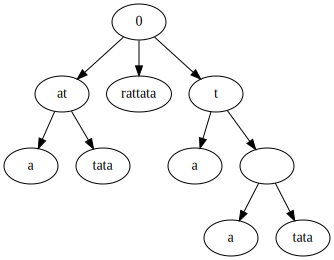

In [6]:
s = "xyzxyaxyz"
s1 ="rattata"
st = SuffixTree()
st.insertAll(s1, verbose=True)
st.printTree(s1)
